# Exploratory data analysis (EDA)

## How to read this notebook

This notebook showcases the use of some descriptive statistics.

It contains the following sections:

* Imports & Settings
* Vorverarbeitung / pre-processing
* Lageparameter / location parameters
* Streuungsmaße / statistical dispersion measures
* Datenverteilungen / data distribution diagrams
* Zusammenhangmaße / measures of association

In each code block something more or less cohesive is done.

The inline-comments describe what is going on.

In some cases insights obtained from a code block
are written down in a Markdown block directly behind that code block.

## Imports & Settings

In [440]:
# in this code block we gather all imports

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.patches import Polygon
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from scipy import stats
import ppscore as pps

# just out of curiosity for the code block about currying
from inspect import signature


In [441]:
# in this code block we change some global settings in effect for all of the following blocks

# in pandas globally set the output format so that floats are rendered with zero fraction digits
# use this with great care since it can easily be misleading
pd.options.display.float_format = '{:.0f}'.format

# for numpy let us configure printing of floats similar
# but with up to 2 fraction digits
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

## Vorverarbeitung / pre-processing

In [442]:
# in this code block we read the CSV file and perform some basic preprocessing

# read the CSV file
# using separator character semicolon
df_pd = pd.read_csv("../../data/Census-Datensatz.csv", sep=';', skipinitialspace=True)

# make column names pythonic
# so that they can be used in code where applicable
df_pd.columns = df_pd.columns.str.replace("-", "_")

# order of columns goes by their name
df_pd = df_pd.reindex(sorted(df_pd.columns), axis=1)

# drop fnlwgt since many analysts seem to discard it
# as it is not an easily usable weight
df_pd.drop(['fnlwgt'],axis=1,inplace=True)

# cleaning strings in object columns
# in particular removing any leading or trailing whitespace
for i in df_pd.columns:
    if df_pd[i].dtype=='object':
        df_pd[i] = df_pd[i].str.strip()

In [443]:
# in this code block we look at the concept of categorical columns in pandas

# we transform a column into a new categorical column and additionally a new integer column
# first we take a closer technical look at the original column income
print(f"\n\ndf['income'].dtype={df_pd['income'].dtype}")
print(df_pd['income'])

# add categorical column income_cat
# as a column of pandas data type category
# first define the category in terms of an object of type CategoricalDtype representing the category
income_categories_pd = CategoricalDtype(categories=["<=50K", ">50K"], ordered=True)
# then use the category for the new column called income_cat
df_pd['income_cat'] = df_pd['income'].astype(income_categories_pd)
# take a closer technical look at the new column
print(f"\n\ndf['income_cat'].dtype={df_pd['income_cat'].dtype}")
print(df_pd['income_cat'])

# additionally also add column income_cat_int
# representing the column income_cat using data type integer
income_column_pd = df_pd[['income']].copy()
# obtain automatically assigned numerical codes for the categories
income_column_category_codes_pd = income_column_pd.income.astype('category').cat.codes
# go with int64 instead of int8 just for internal consistency
df_pd['income_cat_int'] = income_column_category_codes_pd.astype('int64')
# take a closer technical look at the new column
print(f"\n\ndf['income_cat_int'].dtype={df_pd['income_cat_int'].dtype}")
print(df_pd['income_cat_int'])



df['income'].dtype=object
0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557     >50K
32558    <=50K
32559    <=50K
32560     >50K
Name: income, Length: 32561, dtype: object


df['income_cat'].dtype=category
0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557     >50K
32558    <=50K
32559    <=50K
32560     >50K
Name: income_cat, Length: 32561, dtype: category
Categories (2, object): ['<=50K' < '>50K']


df['income_cat_int'].dtype=int64
0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income_cat_int, Length: 32561, dtype: int64


In [444]:
# in this code block columns capital_gain and capital_loss are merged into capital_gain_or_loss

# we perform this on an intermediate data frame with a copy of the two columns
capital_both_pd = df_pd[['capital_gain', 'capital_loss']].copy()
capital_mask_pd = capital_both_pd['capital_gain'] > 0
capital_both_pd['capital_gain'].where(capital_mask_pd, -1 * capital_both_pd['capital_loss'], inplace=True)
capital_both_pd.rename({'capital_gain':'capital_gain_or_loss'}, axis=1, inplace=True)
capital_both_pd.drop('capital_loss', axis=1, inplace=True)
# we are done with feature engineering the new column
# now we add it to our main data frame
df_pd['capital_gain_or_loss'] = capital_both_pd['capital_gain_or_loss']
# order of columns goes by their name
df_pd = df_pd.reindex(sorted(df_pd.columns), axis=1)

# on a side note we choose to sort the data frame by the new column
df_pd.sort_values(by='capital_gain_or_loss', ascending=True, axis=0, inplace=True)


In [445]:
# in this code block we look at the concept of currying from functional programming (FP)

# just out of curiosity
# maybe just skip reading this code block

# decorator to facilitate currying in python
def curry(fn):
    """
    Decorator to curry any function.

    Parameters
    __________
    f : function
        A function to curry.

    Returns
    _______
    fn(...) : object
        The result or a curried function. Depending on the number of parameters given.
    """
    num_args = len(signature(fn).parameters)
    def init(*args, **kwargs):
      def call(*more_args, **more_kwargs):
        all_args = args + more_args
        all_kwargs = dict(**kwargs, **more_kwargs)
        if len(all_args) + len(all_kwargs) >= num_args:
          return fn(*all_args, **all_kwargs)
        else:
          return init(*all_args, **all_kwargs)
      return call
    return init()

# use of the above decorator
@curry
def as_int(f, x) -> int:
    """
    Effectively int(f(x)).

    Parameters
    __________
    f : function
        A function to call.
    x : object
        Value to pass to the function f as the only parameter.

    Returns
    _______
    int(f(x)) : int
        The result as an int.
    """
    y = f(x)
    return int(y)

def is_greater_than_zero(x: int) -> bool:
    b: bool = x > 0
    return b

# is_greater_than_zero_as_int is a function with the first parameter fixed to is_greater_than_zero
# which is something referred to as a curried function
is_greater_than_zero_as_int = as_int(is_greater_than_zero)

In [446]:
# in this code block we derive some columns from given columns just out of curiosity

# we map the columns capital_gain and capital_loss to Boolean columns
# however stored with data type int
# using our curried function is_greater_than_zero_as_int
df_pd['capital_gain_present'] = df_pd['capital_gain'].map(is_greater_than_zero_as_int)
df_pd['capital_loss_present'] = df_pd['capital_loss'].map(is_greater_than_zero_as_int)
df_pd = df_pd.assign(capital_gain_and_loss_present=lambda x: x.capital_gain_present & x.capital_loss_present)
# order of columns goes by their name
df_pd = df_pd.reindex(sorted(df_pd.columns), axis=1)

In [447]:
# in this code block we make use of value counts and also of assert statements just out of curiosity

# we look at the value counts of the new columns created in the previous code block
# to check if everything checks out
capital_flags_value_counts_pd = df_pd[['capital_gain_present', 'capital_loss_present', 'capital_gain_and_loss_present']].value_counts()
# note that capital_flags_value_counts is actually a pandas Series object
# and its first three columns are just part of an index
print(capital_flags_value_counts_pd)
# the sum of the series is therefore just 28330 + 2712 + 1519
capital_flags_value_counts_sum_pd = capital_flags_value_counts_pd.sum()
print(f"\nThe total count computed via pandas value_counts() is: {capital_flags_value_counts_sum_pd}")
assert capital_flags_value_counts_sum_pd == df_pd.shape[0], "Should be equal to the number of rows in our data frame."
# check whether or not capital_gain_and_loss_present is always 0 which think is true
capital_gain_and_loss_present_value_count_pd = df_pd['capital_gain_and_loss_present'].value_counts()
print(capital_gain_and_loss_present_value_count_pd)
# note how in the following use of loc the 0 is a value that occurs in the index
# and that the type of index keys is numeric as opposed to object or string
capital_gain_and_loss_present_value_count_scalar = capital_gain_and_loss_present_value_count_pd.loc[0]
assert capital_gain_and_loss_present_value_count_scalar == df_pd.shape[0], "There should be either capital gain or capital loss, never both."
print(capital_gain_and_loss_present_value_count_scalar)

# since that last assertion holds we know that we never need column capital_gain_and_loss_present
df_pd.drop('capital_gain_and_loss_present', axis=1, inplace=True)
# also we now know for sure that we never need the original column capital_gain
df_pd.drop('capital_gain', axis=1, inplace=True)
# also we now know for sure that we never need the original column capital_loss
df_pd.drop('capital_loss', axis=1, inplace=True)

# note that we used inplace=True for dropping these columns as a performance optimization
# thus in that data frame object these columns will be gone after each execution of this code block
# and might affect individual user-requested executions of certain previous code blocks
# unless everything is repeated from the start

capital_gain_present  capital_loss_present  capital_gain_and_loss_present
0                     0                     0                                28330
1                     0                     0                                 2712
0                     1                     0                                 1519
dtype: int64

The total count computed via pandas value_counts() is: 32561
0    32561
Name: capital_gain_and_loss_present, dtype: int64
32561


In [448]:
# in this code block we just print our data frame

# auto-magically via the Jupyter Notebook output facility
df_pd

,age,capital_gain_or_loss,capital_gain_present,capital_loss_present,education,education_num,hours_per_week,income,income_cat,income_cat_int,marital_status,native_country,occupation,race,relationship,sex,workclass
30781,66,-4356,0,1,Some-college,10,40,<=50K,<=50K,0,Widowed,United-States,?,Black,Unmarried,Female,?
14756,82,-4356,0,1,HS-grad,9,18,<=50K,<=50K,0,Widowed,United-States,Exec-managerial,White,Not-in-family,Female,Private
8963,90,-4356,0,1,HS-grad,9,40,<=50K,<=50K,0,Widowed,United-States,?,White,Not-in-family,Female,?
23802,41,-3900,0,1,Some-college,10,40,<=50K,<=50K,0,Separated,United-States,Prof-specialty,White,Own-child,Female,Private
20416,54,-3900,0,1,7th-8th,4,40,<=50K,<=50K,0,Divorced,United-States,Machine-op-inspct,White,Unmarried,Female,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15100,62,99999,1,0,Bachelors,13,40,>50K,>50K,1,Divorced,United-States,Sales,White,Not-in-family,Male,Self-emp-inc
10661,59,99999,1,0,Prof-school,15,40,>50K,>50K,1,Married-civ-spouse,India,Prof-specialty,Asian-Pac-Islander,Husband,Male,Private
2103,43,99999,1,0,Some-college,10,55,>50K,>50K,1,Married-civ-spouse,United-States,Sales,White,Husband,Male,Self-emp-inc
25178,45,99999,1,0,Doctorate,16,30,>50K,>50K,1,Never-married,United-States,Prof-specialty,White,Not-in-family,Male,Private


In [449]:
# in this code block we describe our data frame including all columns no matter the data types

# note how some statistics in the description yield NaN (not a number) for non-numeric columns
# we also request additional percentiles from the pandas describe function
df_pd.describe(include='all',percentiles=[.05, .10, .25, .5, .75, .90, .95, .96, .97, .98, .99])

,age,capital_gain_or_loss,capital_gain_present,capital_loss_present,education,education_num,hours_per_week,income,income_cat,income_cat_int,marital_status,native_country,occupation,race,relationship,sex,workclass
count,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,NaN,NaN,NaN,NaN,16,NaN,NaN,2,2,NaN,7,42,15,5,6,2,9
top,NaN,NaN,NaN,NaN,HS-grad,NaN,NaN,<=50K,<=50K,NaN,Married-civ-spouse,United-States,Prof-specialty,White,Husband,Male,Private
freq,NaN,NaN,NaN,NaN,10501,NaN,NaN,24720,24720,NaN,14976,29170,4140,27816,13193,21790,22696
mean,39,990,0,0,NaN,10,40,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,14,7409,0,0,NaN,3,12,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,17,-4356,0,0,NaN,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5%,19,0,0,0,NaN,5,18,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10%,22,0,0,0,NaN,7,24,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,28,0,0,0,NaN,9,40,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [450]:
# in this code block we make a new pandas data frame df_int_pd out of our original df_pd

# which contains only certain integer columns in this case
# retain only some of the numeric columns
# composing an integer data frame
numeric_columns = ['age', 'capital_gain_or_loss', 'hours_per_week']
df_pd_numeric = df_pd[numeric_columns].copy()
df_pd_numeric.sort_values(by='capital_gain_or_loss', axis=0, ascending=True, inplace=True)
print(df_pd_numeric)
# ensure datatype int32
df_int_pd = df_pd_numeric.astype('int64')
# keep our column income_cat_int also in this new data frame
df_int_pd['income_cat_int'] = df_pd['income_cat_int'].copy()
# we also take along with us a numpy int64 version of the just created pandas integer data frame
df_int_np = df_int_pd.to_numpy(dtype = 'int64')
# we also take along with us a numpy float32 version of the just created pandas integer data frame
df_float32_np = df_int_pd.to_numpy(dtype = 'float32')
#data_int.describe(percentiles=[.05, .10, .25, .5, .75, .90, .95, .96, .97, .98, .99]).apply('{:.0f}'.format)
# the above out-commented line raises error unsupported format string passed to Series.__format__
# so instead we use pd.options.display.float_format = '{:.0f}'.format globally after pandas import
df_int_pd.describe(include='all', percentiles=[.05, .10, .25, .5, .75, .90, .95, .96, .97, .98, .99])

       age  capital_gain_or_loss  hours_per_week
30781   66                 -4356              40
14756   82                 -4356              18
8963    90                 -4356              40
23802   41                 -3900              40
20416   54                 -3900              40
...    ...                   ...             ...
3368    40                 99999              70
19080   47                 99999              60
19084   52                 99999              30
15604   50                 99999              55
6524    49                 99999              80

[32561 rows x 3 columns]


,age,capital_gain_or_loss,hours_per_week,income_cat_int
count,32561,32561,32561,32561
mean,39,990,40,0
std,14,7409,12,0
min,17,-4356,1,0
5%,19,0,18,0
10%,22,0,24,0
25%,28,0,40,0
50%,37,0,40,0
75%,48,0,45,0
90%,58,0,55,1


In [451]:
df_int_pd

,age,capital_gain_or_loss,hours_per_week,income_cat_int
30781,66,-4356,40,0
14756,82,-4356,18,0
8963,90,-4356,40,0
23802,41,-3900,40,0
20416,54,-3900,40,0
...,...,...,...,...
3368,40,99999,70,1
19080,47,99999,60,1
19084,52,99999,30,1
15604,50,99999,55,1


In [452]:
df_int_np

array([[   66, -4356,    40,     0],
       [   82, -4356,    18,     0],
       [   90, -4356,    40,     0],
       ...,
       [   52, 99999,    30,     1],
       [   50, 99999,    55,     1],
       [   49, 99999,    80,     1]])

In [453]:
df_float32_np

array([[66.00, -4356.00, 40.00, 0.00],
       [82.00, -4356.00, 18.00, 0.00],
       [90.00, -4356.00, 40.00, 0.00],
       ...,
       [52.00, 99999.00, 30.00, 1.00],
       [50.00, 99999.00, 55.00, 1.00],
       [49.00, 99999.00, 80.00, 1.00]], dtype=float32)

## Lageparameter / location parameters

In [454]:
# in this code block we look at some location parameters

# mean examples
mean_pd_int = df_int_pd.mean(numeric_only=True)
print(f"\nmean (pandas) int\n {mean_pd_int}")
mean_np_int = df_int_np.mean(axis=0, dtype='int64')
print(f"\nmean (numpy) int64\n{mean_np_int}")
mean_np_float32 = df_float32_np.mean(axis=0, dtype='float32')
print(f"\nmean (numpy) float32\n{mean_np_float32}")

# trimmed mean examples
trimmed_mean_scipy_with_numpy_10 = stats.trim_mean(df_int_np.astype('float32'), proportiontocut=0.10, axis=0)
print(f"\ntrimmed mean (scipy with numpy) cut off percentage 10%\n{trimmed_mean_scipy_with_numpy_10}")
trimmed_mean_scipy_with_numpy_15 = stats.trim_mean(df_int_np.astype('float32'), proportiontocut=0.15, axis=0)
print(f"\ntrimmed mean (scipy with numpy) cut off percentage 15%\n{trimmed_mean_scipy_with_numpy_15}")

# weighted mean examples
# we use the hours_per_week as weights which does not make sense
# just to showcase the numpy function called average
weighted_mean_float32_np = np.average( df_float32_np[:,3], weights = df_float32_np[:,0], axis=0)
print(f"\nweighted mean of column age (numpy) float32\n{weighted_mean_float32_np}")

# median examples
# similar to the 50th percentile
median_pd_int = df_int_pd.median(numeric_only=True)
print(f"\nmedian (pandas) int\n{median_pd_int}")

# mode examples
# the most frequently occurring value
mode_pd_int = df_int_pd.mode(numeric_only=True)
print(f"\nmode (pandas) int\n{mode_pd_int}")
# the most frequently occurring value in column hours_per_week
hours_per_week_mode_pd_int = df_int_pd['hours_per_week'].mode()
print(f"\nmode of column hours_per_week (pandas) int\n{hours_per_week_mode_pd_int}")
# the most frequently occurring value in column hours_per_week with occurrence count
hours_per_week_mode_pd_int_with_value_count = df_int_pd['hours_per_week'].value_counts().iloc[[0]]
print("\nmode of column hours_per_week with value count (pandas) int\n"
    + f"{hours_per_week_mode_pd_int_with_value_count}")


mean (pandas) int
 age                     39
capital_gain_or_loss   990
hours_per_week          40
income_cat_int           0
dtype: float64

mean (numpy) int64
[ 38 990  40   0]

mean (numpy) float32
[38.58 990.35 40.44 0.24]

trimmed mean (scipy with numpy) cut off percentage 10%
[37.69 0.00 40.55 0.18]

trimmed mean (scipy with numpy) cut off percentage 15%
[37.48 0.00 40.74 0.13]

weighted mean of column age (numpy) float32
0.276187926530838

median (pandas) int
age                    37
capital_gain_or_loss    0
hours_per_week         40
income_cat_int          0
dtype: float64

mode (pandas) int
   age  capital_gain_or_loss  hours_per_week  income_cat_int
0   36                     0              40               0

mode of column hours_per_week (pandas) int
0    40
Name: hours_per_week, dtype: int64

mode of column hours_per_week with value count (pandas) int
40    15217
Name: hours_per_week, dtype: int64


## Streuungsmaße / statistical dispersion measures

In [455]:
# in this code block we compute some statistical dispersion measures

# range examples
def range_pd(df: pd.DataFrame):
    result = df.max() - df.min()
    return result
range_int_pd = range_pd(df_int_pd)
print(f"\nrange (pandas)\n{range_int_pd}")
def range_np(a: np.ndarray) -> np.ndarray:
    result = a.max(axis=0) - a.min(axis=0)
    return result
range_int_np = range_np(df_int_np)
print(f"\nrange (numpy) int\n{range_int_np}")
range_float32_np = range_np(df_float32_np)
print(f"\nrange (numpy) float32\n{range_float32_np}")

# mean absolute deviation
mad_pd_int = df_int_pd.mad()
print(f"\nmean absolute deviation (pandas) int\n{mad_pd_int}")
mad_np_int = np.mean(np.absolute(df_int_np - np.mean(df_int_np, axis=0)), axis=0).astype('int64')
print(f"\nmean absolute deviation (numpy) int\n{mad_np_int}")
mad_np_float32 = np.mean(np.absolute(df_float32_np - np.mean(df_float32_np, axis=0)), axis=0)
print(f"\nmean absolute deviation (numpy) float32\n{mad_np_float32}")

# variance examples
variance_pd = df_int_pd.var()
print(f"\nvariance (pandas) int\n{variance_pd}")
variance_int_np = df_int_np.var(axis=0).astype('int64')
print(f"\nvariance (numpy) int\n{variance_int_np}")
variance_float32_np = df_float32_np.var(axis=0)
print(f"\nvariance (numpy) float32\n{variance_float32_np}")

# standard deviation examples
standard_deviation_pd = df_int_pd.std()
print(f"\nstandard deviation (pandas) int\n{standard_deviation_pd}")
standard_deviation_int_np = df_int_np.std(axis=0).astype('int64')
print(f"\nstandard deviation (numpy) int\n{standard_deviation_int_np}")
standard_deviation_float32_np = df_float32_np.std(axis=0)
print(f"\nstandard deviation (numpy) float32\n{standard_deviation_float32_np}")

# percentile examples
percentile_25_int_np = np.percentile(df_int_np, 25.0, axis=0).astype('int64')
print(f"\npercentile 25 (numpy) int\n{percentile_25_int_np}")
percentile_50_int_np = np.percentile(df_int_np, 50.0, axis=0).astype('int64')
print(f"\npercentile 50 (numpy) int\n{percentile_50_int_np}")
percentile_75_float32_np = np.percentile(df_float32_np, 75.0, axis=0)
print(f"\npercentile 75 (numpy) float32\n{percentile_75_float32_np}")
percentile_90_int_np = np.percentile(df_int_np, 90.0, axis=0).astype('int64')
print(f"\npercentile 90 (numpy) int\n{percentile_90_int_np}")

# quantile examples
quantile_25_int_pd = df_int_pd.quantile(0.25)
print(f"\nquantile 0.25 (pandas) int\n{quantile_25_int_pd}")
quantile_25_int_np = np.quantile(df_int_np, 0.25, axis=0).astype('int64')
print(f"\nquantile 0.25 (numpy) int\n{quantile_25_int_np}")
quantile_50_int_np = np.quantile(df_int_np, 0.5, axis=0).astype('int64')
print(f"\nquantile 0.5 (numpy) int\n{quantile_50_int_np}")
quantile_75_float32_np = np.quantile(df_float32_np, 0.75, axis=0)
print(f"\nquantile 0.75 (numpy) float32\n{quantile_75_float32_np}")
quantile_100_int_np = np.quantile(df_int_np, 1.0, axis=0).astype('int64')
print(f"\nquantile 1.0 (numpy) int\n{quantile_100_int_np}")

# inter-quartile range examples
# the inter-quartile range (IQR) is the difference between the 75th and 25th percentile of the data
# it is a measure of the dispersion similar to standard deviation or variance
# but is much more robust against outliers
inter_quartile_range_scipy_int_np = stats.iqr(df_int_np, axis=0).astype('int64')
print(f"\ninter-quartile range (scipy with numpy) int\n{inter_quartile_range_scipy_int_np}")
inter_quartile_range_scipy_float32_np = stats.iqr(df_float32_np, axis=0)
print(f"\ninter-quartile range (scipy with numpy) float32\n{inter_quartile_range_scipy_float32_np}")




range (pandas)
age                         73
capital_gain_or_loss    104355
hours_per_week              98
income_cat_int               1
dtype: int64

range (numpy) int
[    73 104355     98      1]

range (numpy) float32
[73.00 104355.00 98.00 1.00]

mean absolute deviation (pandas) int
age                      11
capital_gain_or_loss   1992
hours_per_week            8
income_cat_int            0
dtype: float64

mean absolute deviation (numpy) int
[  11 1991    7    0]

mean absolute deviation (numpy) float32
[11.19 1991.59 7.58 0.37]

variance (pandas) int
age                         186
capital_gain_or_loss   54893088
hours_per_week              152
income_cat_int                0
dtype: float64

variance (numpy) int
[     186 54891401      152        0]

variance (numpy) float32
[186.06 54891404.00 152.45 0.18]

standard deviation (pandas) int
age                      14
capital_gain_or_loss   7409
hours_per_week           12
income_cat_int            0
dtype: float64

standard 

/var/folders/h2/lkcg_8md1x38x9b_fv91s7pw0000gn/T/ipykernel_1771/3362677423.py:18: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad_pd_int = df_int_pd.mad()


## Datenverteilungen / data distribution diagrams

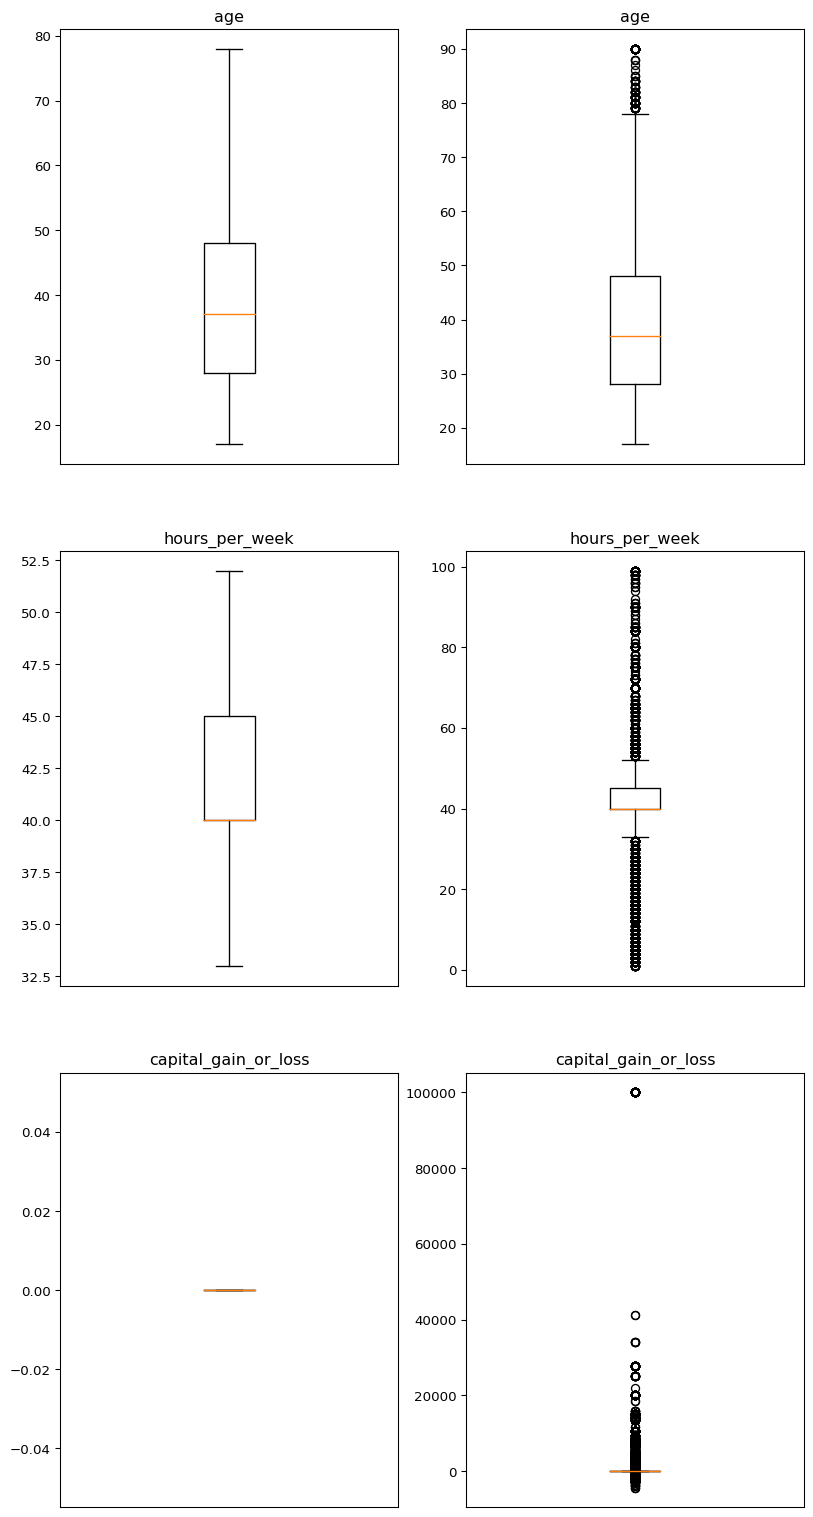

In [456]:
# in this code block we compute and show some box plots

# both without and with showing outliers
fig, axs = plt.subplots(3, 2)

axs[0, 0].boxplot(df_int_pd['age'], showfliers=False)
axs[0, 0].set_title('age')
axs[0, 1].boxplot(df_int_pd['age'], showfliers=True)
axs[0, 1].set_title('age')
axs[1, 0].boxplot(df_int_pd['hours_per_week'], showfliers=False)
axs[1, 0].set_title('hours_per_week')
axs[1, 1].boxplot(df_int_pd['hours_per_week'], showfliers=True)
axs[1, 1].set_title('hours_per_week')
axs[2, 0].boxplot(df_int_pd['capital_gain_or_loss'], showfliers=False)
axs[2, 0].set_title('capital_gain_or_loss')
axs[2, 1].boxplot(df_int_pd['capital_gain_or_loss'], showfliers=True)
axs[2, 1].set_title('capital_gain_or_loss')

for ax in axs.ravel():
    #ax.set_xticks([])
    ax.xaxis.set_major_locator(plt.NullLocator())

fig.set_size_inches(10.0, 20.0)
fig.set_dpi(96.0)


array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='capital_gain_or_loss', ylabel='age'>,
        <Axes: xlabel='hours_per_week', ylabel='age'>,
        <Axes: xlabel='income_cat_int', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='capital_gain_or_loss'>,
        <Axes: xlabel='capital_gain_or_loss', ylabel='capital_gain_or_loss'>,
        <Axes: xlabel='hours_per_week', ylabel='capital_gain_or_loss'>,
        <Axes: xlabel='income_cat_int', ylabel='capital_gain_or_loss'>],
       [<Axes: xlabel='age', ylabel='hours_per_week'>,
        <Axes: xlabel='capital_gain_or_loss', ylabel='hours_per_week'>,
        <Axes: xlabel='hours_per_week', ylabel='hours_per_week'>,
        <Axes: xlabel='income_cat_int', ylabel='hours_per_week'>],
       [<Axes: xlabel='age', ylabel='income_cat_int'>,
        <Axes: xlabel='capital_gain_or_loss', ylabel='income_cat_int'>,
        <Axes: xlabel='hours_per_week', ylabel='income_cat_int'>,
        <Axes: xlabel='income_cat_int', ylabel=

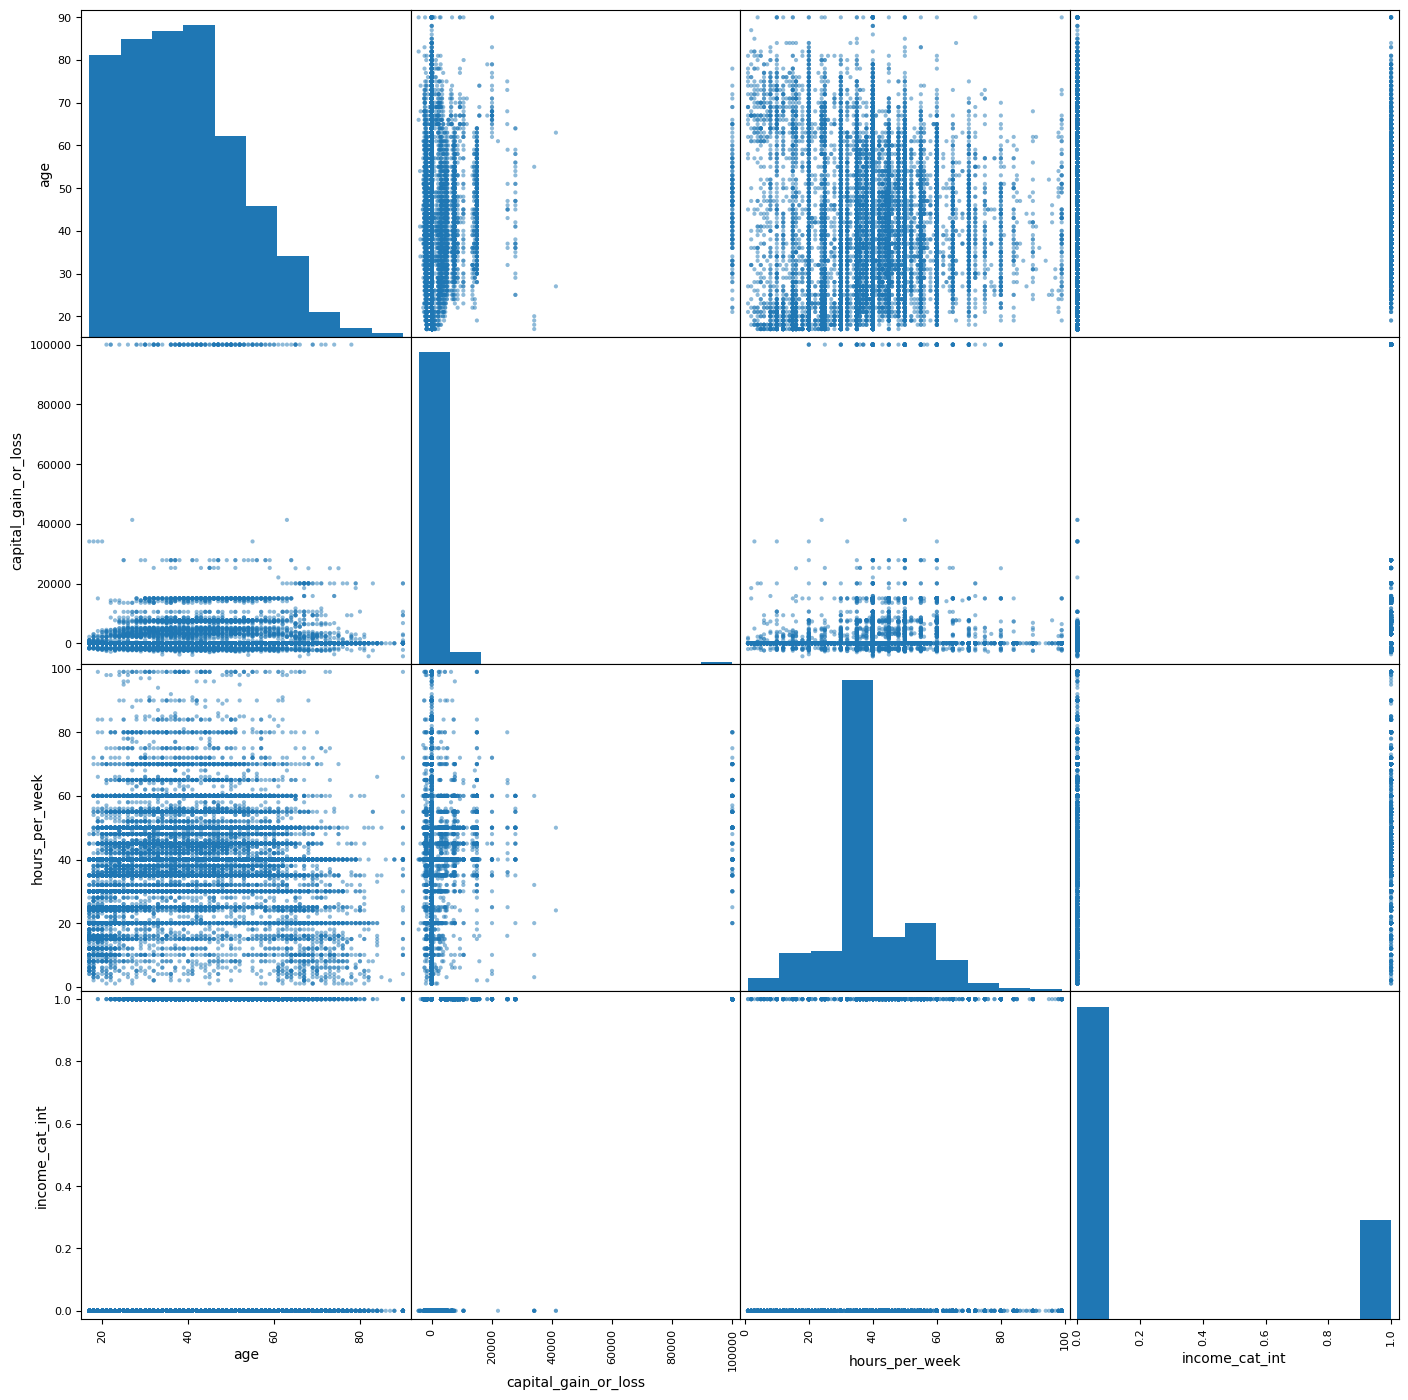

In [457]:
# in this code block we compute and show a practical matrix-like arrangement of scatter plots

# known as a scatter matrix
# consisting of scatter plots
# and in this case with histograms along the main diagonal
pd.plotting.scatter_matrix(df_int_pd,
                           figsize=(17, 17),
                           diagonal = 'hist')

## Insights

### hours_per_week over age
* Diverse hours per week up to 35 are more common among young and old people.
* However, e.g. exactly 20 hours per week as part_time work seems common across all age groups.

### capital_gain_or_loss over age
* Capital gain appears to be almost independent from age.
* However, enjoying higher capital gains is more likely for people over 25 years.

### capital_gain_or_loss over age
* Older people experience slightly more often higher capital losses.

### income_cat over age
* Income category >50K is more likely for people over 25 years.

### age histogram
* Many people retire between 50 and 70 years of age.


## Zusammenhangmaße / association measures

array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='capital_gain_or_loss', ylabel='age'>,
        <Axes: xlabel='hours_per_week', ylabel='age'>,
        <Axes: xlabel='income_cat_int', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='capital_gain_or_loss'>,
        <Axes: xlabel='capital_gain_or_loss', ylabel='capital_gain_or_loss'>,
        <Axes: xlabel='hours_per_week', ylabel='capital_gain_or_loss'>,
        <Axes: xlabel='income_cat_int', ylabel='capital_gain_or_loss'>],
       [<Axes: xlabel='age', ylabel='hours_per_week'>,
        <Axes: xlabel='capital_gain_or_loss', ylabel='hours_per_week'>,
        <Axes: xlabel='hours_per_week', ylabel='hours_per_week'>,
        <Axes: xlabel='income_cat_int', ylabel='hours_per_week'>],
       [<Axes: xlabel='age', ylabel='income_cat_int'>,
        <Axes: xlabel='capital_gain_or_loss', ylabel='income_cat_int'>,
        <Axes: xlabel='hours_per_week', ylabel='income_cat_int'>,
        <Axes: xlabel='income_cat_int', ylabel=

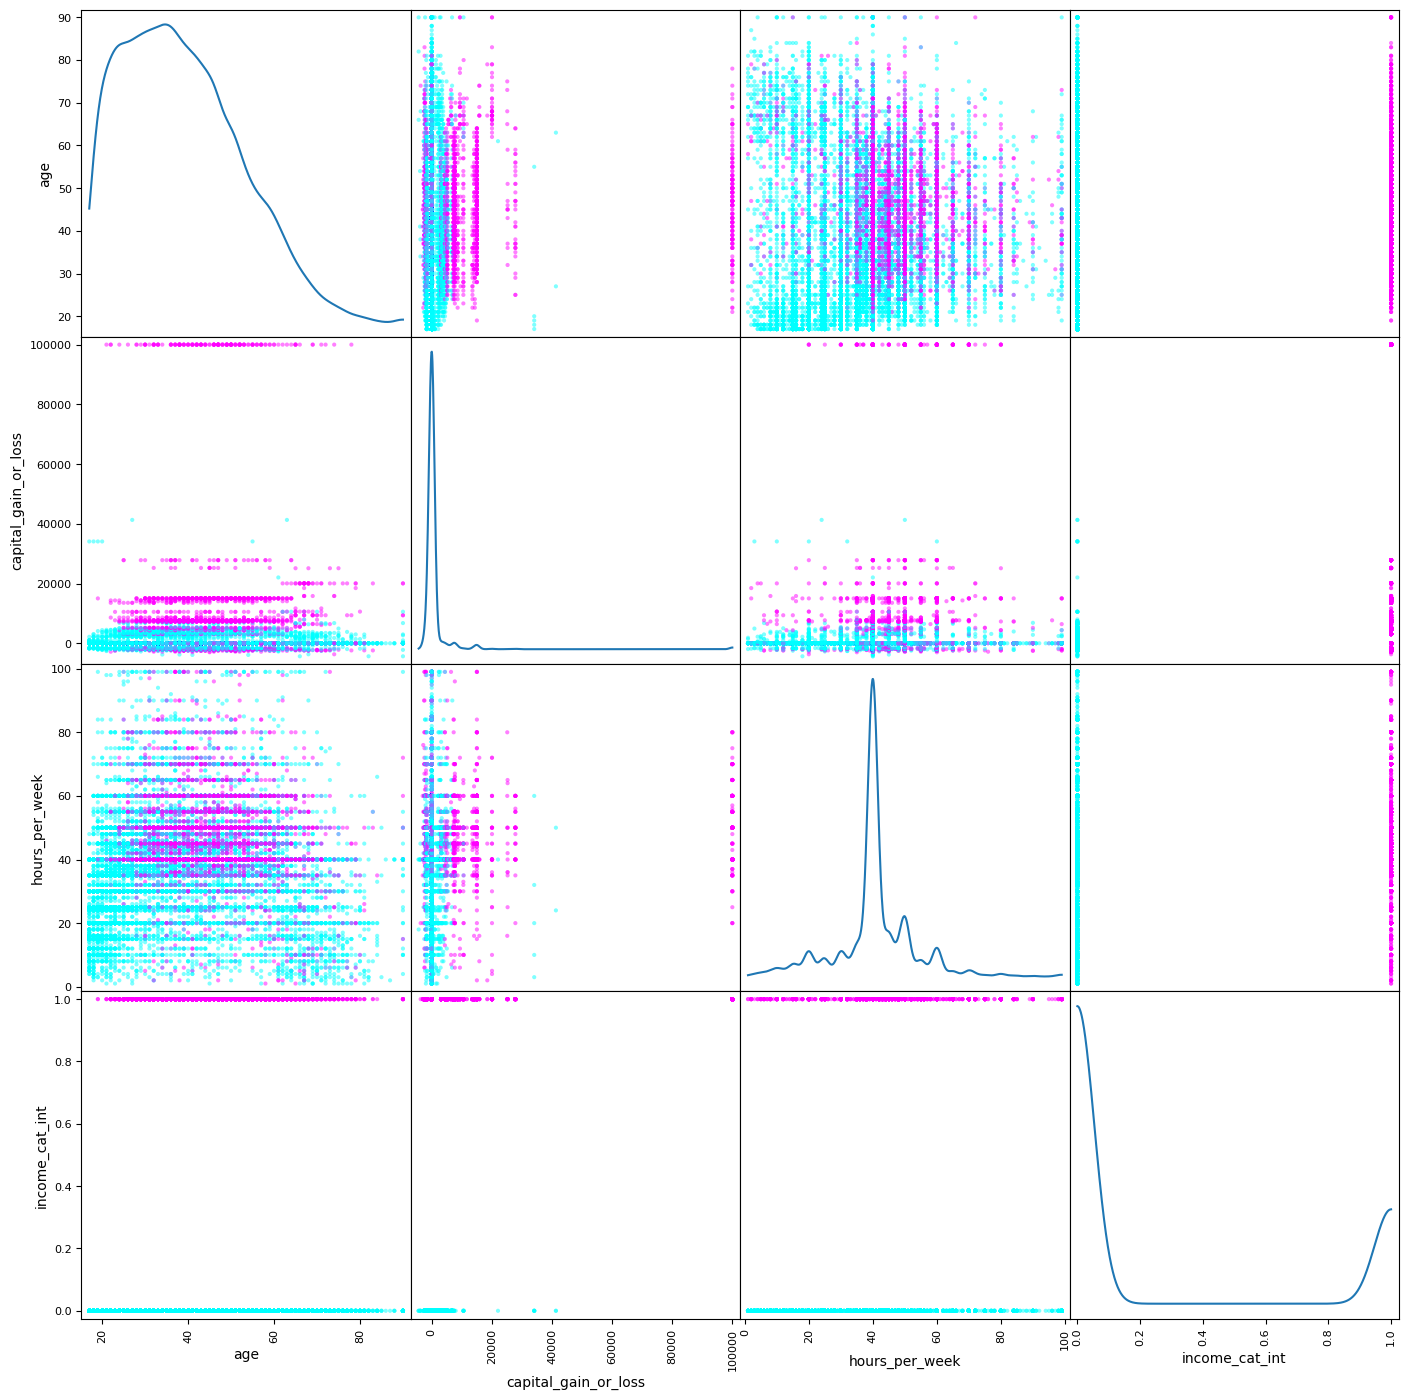

In [458]:
# in this code block we compute and show a practical matrix-like arrangement of scatter plots

# known as a scatter matrix
# consisting of scatter plots
# and in this case with density lines along the main diagonal
# and also with color range influenced via income_cat_int value
# in order to distinguish points or point clouds formed out of rows that have
# income_cat_int <=50K == 0 => turquoise palette
# income_cat_int >50K == 1 => pink palette
pd.plotting.scatter_matrix(df_int_pd,
                           c=df_int_pd['income_cat_int'],
                           figsize=(17, 17),
                           cmap = cm['cool'],
                           diagonal = 'kde')

## Insights

### hours_per_week over age colored by income_cat
* Income category >50K is more likely for peopke with 40 or more hours per week.

### hours_per_week distribution function
* 40 hours per week are predominant.


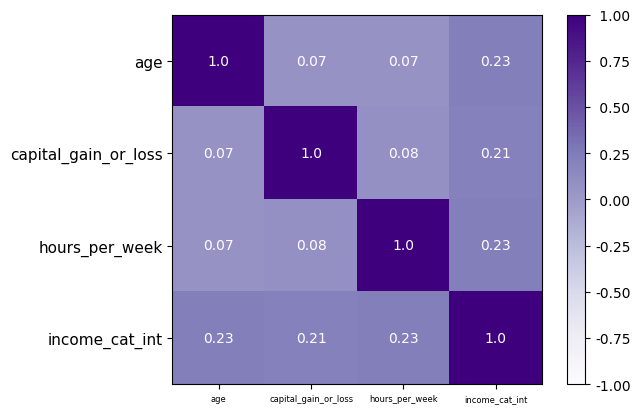

In [459]:
# in this code block we mainly compute and show a linear correlation matrix using numpy

# first look how it goes via pandas
# Pearson product_moment correlation coefficients via pandas
pd.options.display.float_format = '{:.2f}'.format
pd_correlation_matrix = df_int_pd.astype(dtype=float, copy=True).corr(method='pearson', numeric_only=True)
#print(pd_correlation_matrix)
pd.options.display.float_format = '{:.0f}'.format

# now compute basically the same but faster via numpy
df_int_np_correlation_matrix = np.corrcoef(df_int_np, rowvar=False).round(decimals=2)

# visualize that linear correlation matrix obtained via numpy using matplotlib
fig, ax = plt.subplots()
im = ax.imshow(df_int_np_correlation_matrix, cmap='Purples')
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2, 3), ticklabels=('age', 'capital_gain_or_loss', 'hours_per_week', 'income_cat_int'))
ax.yaxis.set(ticks=(0, 1, 2, 3), ticklabels=('age', 'capital_gain_or_loss', 'hours_per_week', 'income_cat_int'))
ax.tick_params(axis='x', which='major', labelsize=6)
ax.tick_params(axis='x', which='minor', labelsize=5)
ax.tick_params(axis='y', which='major', labelsize=11)
ax.tick_params(axis='y', which='minor', labelsize=10)
ax.set_ylim(3.5, -0.5)
for i in range(4):
    for j in range(4):
        ax.text(j, i, df_int_np_correlation_matrix[i, j], ha='center', va='center',
                color='white')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()


## Insights

### correlation matrix
* Only week linear correlations present in our consensus sample.
* It would be hard to predict the income category using some plain linear regression.

In [460]:
# in this code block we try out pandas sample covariance matrix

# just out of curiosity
df_int_pd_covariance_matrix = df_int_pd.astype(dtype=float, copy=True).cov(numeric_only=True)
df_int_pd_covariance_matrix

,age,capital_gain_or_loss,hours_per_week,income_cat_int
age,186,7507,12,1
capital_gain_or_loss,7507,54893088,6880,679
hours_per_week,12,6880,152,1
income_cat_int,1,679,1,0


## Insights

Disclaimer: The sample mean and sample covariance are not robust statistics, meaning that they are sensitive to outliers.

### sample covariance matrix
* The negative covariance between capital gain and capital loss supposedly tells us that higher capital gains come along with lower capital losses.


In [461]:
# this code block is out-commented as an example of what did not work

# here the library ppscore internally uses DecisionTreeRegressor
# because all columns are of some numeric data type
# this however yields bad ppscore results in this case
# in particular with respect to the column income_cat_int which contains only the numbers 0 or 1
# and thus classification (DecisionTreeClassifier) would be more appropriate
#predictive_power_score_matrix_pd = pps.matrix(df_int_pd.astype(float), output='df')
#predictive_power_score_matrix_pd.style.background_gradient(cmap='twilight', low=0.0, high=1.0)
# see next code block for the actual solution


In [462]:
# in this code block we let ppscore compute Predictive Power Scores with column income_cat as target

# income_cat is our categorical representation of the original column income
# the library thus uses DecisionTreeClassifier and the ppscore results make sense
predictive_power_scores_pd = pps.predictors(df_pd, y='income_cat', output='df')
predictive_power_scores_pd.style.background_gradient(cmap='twilight', low=0.0, high=1.0)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,income,income_cat,1.000000,classification,True,weighted F1,0.655280,1.000000,DecisionTreeClassifier()
1,income_cat_int,income_cat,1.000000,classification,True,weighted F1,0.655280,1.000000,DecisionTreeClassifier()
2,capital_gain_or_loss,income_cat,0.403340,classification,True,weighted F1,0.655280,0.794319,DecisionTreeClassifier()
3,education,income_cat,0.238804,classification,True,weighted F1,0.655280,0.737601,DecisionTreeClassifier()
4,education_num,income_cat,0.238804,classification,True,weighted F1,0.655280,0.737601,DecisionTreeClassifier()
5,capital_gain_present,income_cat,0.231648,classification,True,weighted F1,0.655280,0.735134,DecisionTreeClassifier()
6,workclass,income_cat,0.086299,classification,True,weighted F1,0.655280,0.685029,DecisionTreeClassifier()
7,relationship,income_cat,0.073941,classification,True,weighted F1,0.655280,0.680769,DecisionTreeClassifier()
8,capital_loss_present,income_cat,0.072133,classification,True,weighted F1,0.655280,0.680146,DecisionTreeClassifier()
9,age,income_cat,0.032264,classification,True,weighted F1,0.655280,0.666402,DecisionTreeClassifier()


In [463]:
# in this code block we take look at the Predictive Power Score matrix for all of our data frame

predictive_power_score_matrix_all_pd = pps.matrix(df_pd, output='df')
predictive_power_score_matrix_all_pd.style.background_gradient(cmap='twilight', low=0.0, high=1.0)

/Users/sven/gh/fullstack-ml-academy-homework/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/Users/sven/gh/fullstack-ml-academy-homework/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/Users/sven/gh/fullstack-ml-academy-homework/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/sven/gh/fullstack-ml-academy-homework/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/sven/gh/fullstack-ml-academy-homework/.venv/lib/python3.9/site-packages/s

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,age,age,1.000000,predict_itself,True,None,0.000000,1.000000,None
1,age,capital_gain_or_loss,0.000000,regression,True,mean absolute error,1179.972400,1995.598065,DecisionTreeRegressor()
2,age,capital_gain_present,0.000000,regression,True,mean absolute error,0.082200,0.148178,DecisionTreeRegressor()
3,age,capital_loss_present,0.000000,regression,True,mean absolute error,0.047000,0.089399,DecisionTreeRegressor()
4,age,education,0.026600,classification,True,weighted F1,0.199200,0.220501,DecisionTreeClassifier()
5,age,education_num,0.000000,regression,True,mean absolute error,1.870200,1.910931,DecisionTreeRegressor()
6,age,hours_per_week,0.000000,regression,True,mean absolute error,7.538200,8.032903,DecisionTreeRegressor()
7,age,income,0.032264,classification,True,weighted F1,0.655280,0.666402,DecisionTreeClassifier()
8,age,income_cat,0.032264,classification,True,weighted F1,0.655280,0.666402,DecisionTreeClassifier()
9,age,income_cat_int,0.000000,regression,True,mean absolute error,0.240800,0.328858,DecisionTreeRegressor()


## Descriptive Statistics

Just listing some concepts. This section can be seen as an appendix of backup.

### Lageparameter
* Arithmetisches Mittel / Durchschnitt / average
* Getrimmtes Mittel / truncated mean
* Gewichtetes Mittel / weighted arithmetic mean
* Median

### Streuungsmaße
* Spannweite / range
* Mittlere Absolute Abweichung / mean absolute deviation
* Varianz / variance
* Standardabweichung / standard deviation
* Quantil, Perzentil, Quartil
* Interquartilsabstand / Spannweite vom Perzentil 25 zum Perzentil 75 / interquartil range
* Variationskoeffizient
* Empirischer Quartilsdispersionskoeffizient

### Verteilungen
* Boxplot
* Histogram
* Dichtediagramm

### Zusammenhangmaße
* Korrelationskoeffizient / correlation coefficient
* Korrelationsmatrix / correlation matrix
* Streudiagramm / scatter plot
* Streudiagrammmatrix / scatter matrix
* Predictive Power Score